# Домашнее задание 4 (семинар 5)

**Цель:** обучить метод опорных векторов (**SVM**) на датасете с рукописными цифрами (<code>MNIST</code>)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [2]:
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
import seaborn as sns
sns.set()

In [4]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

Выгрузим датасет <code>MNIST</code> (рукописные цифры)

In [6]:
import tensorflow as tf

2023-12-17 16:53:52.501962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Найдем размеры обучающей и тестовой выборок.

In [8]:
X_train.shape

(60000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

В обучающей выборке 60000 изображений, в тестовой $-$ 10000. Все изображения имеют размер (28, 28) пикселей. Сократим размеры двух выборок в 5 раз.

In [10]:
X_train = X_train[:X_train.shape[0] // 5]
y_train = y_train[:y_train.shape[0] // 5]

In [11]:
X_test = X_test[:X_test.shape[0] // 5]
y_test = y_test[:y_test.shape[0] // 5]

In [12]:
X_train.shape

(12000, 28, 28)

In [13]:
X_test.shape

(2000, 28, 28)

Выведем несколько изображений рукописных цифр.

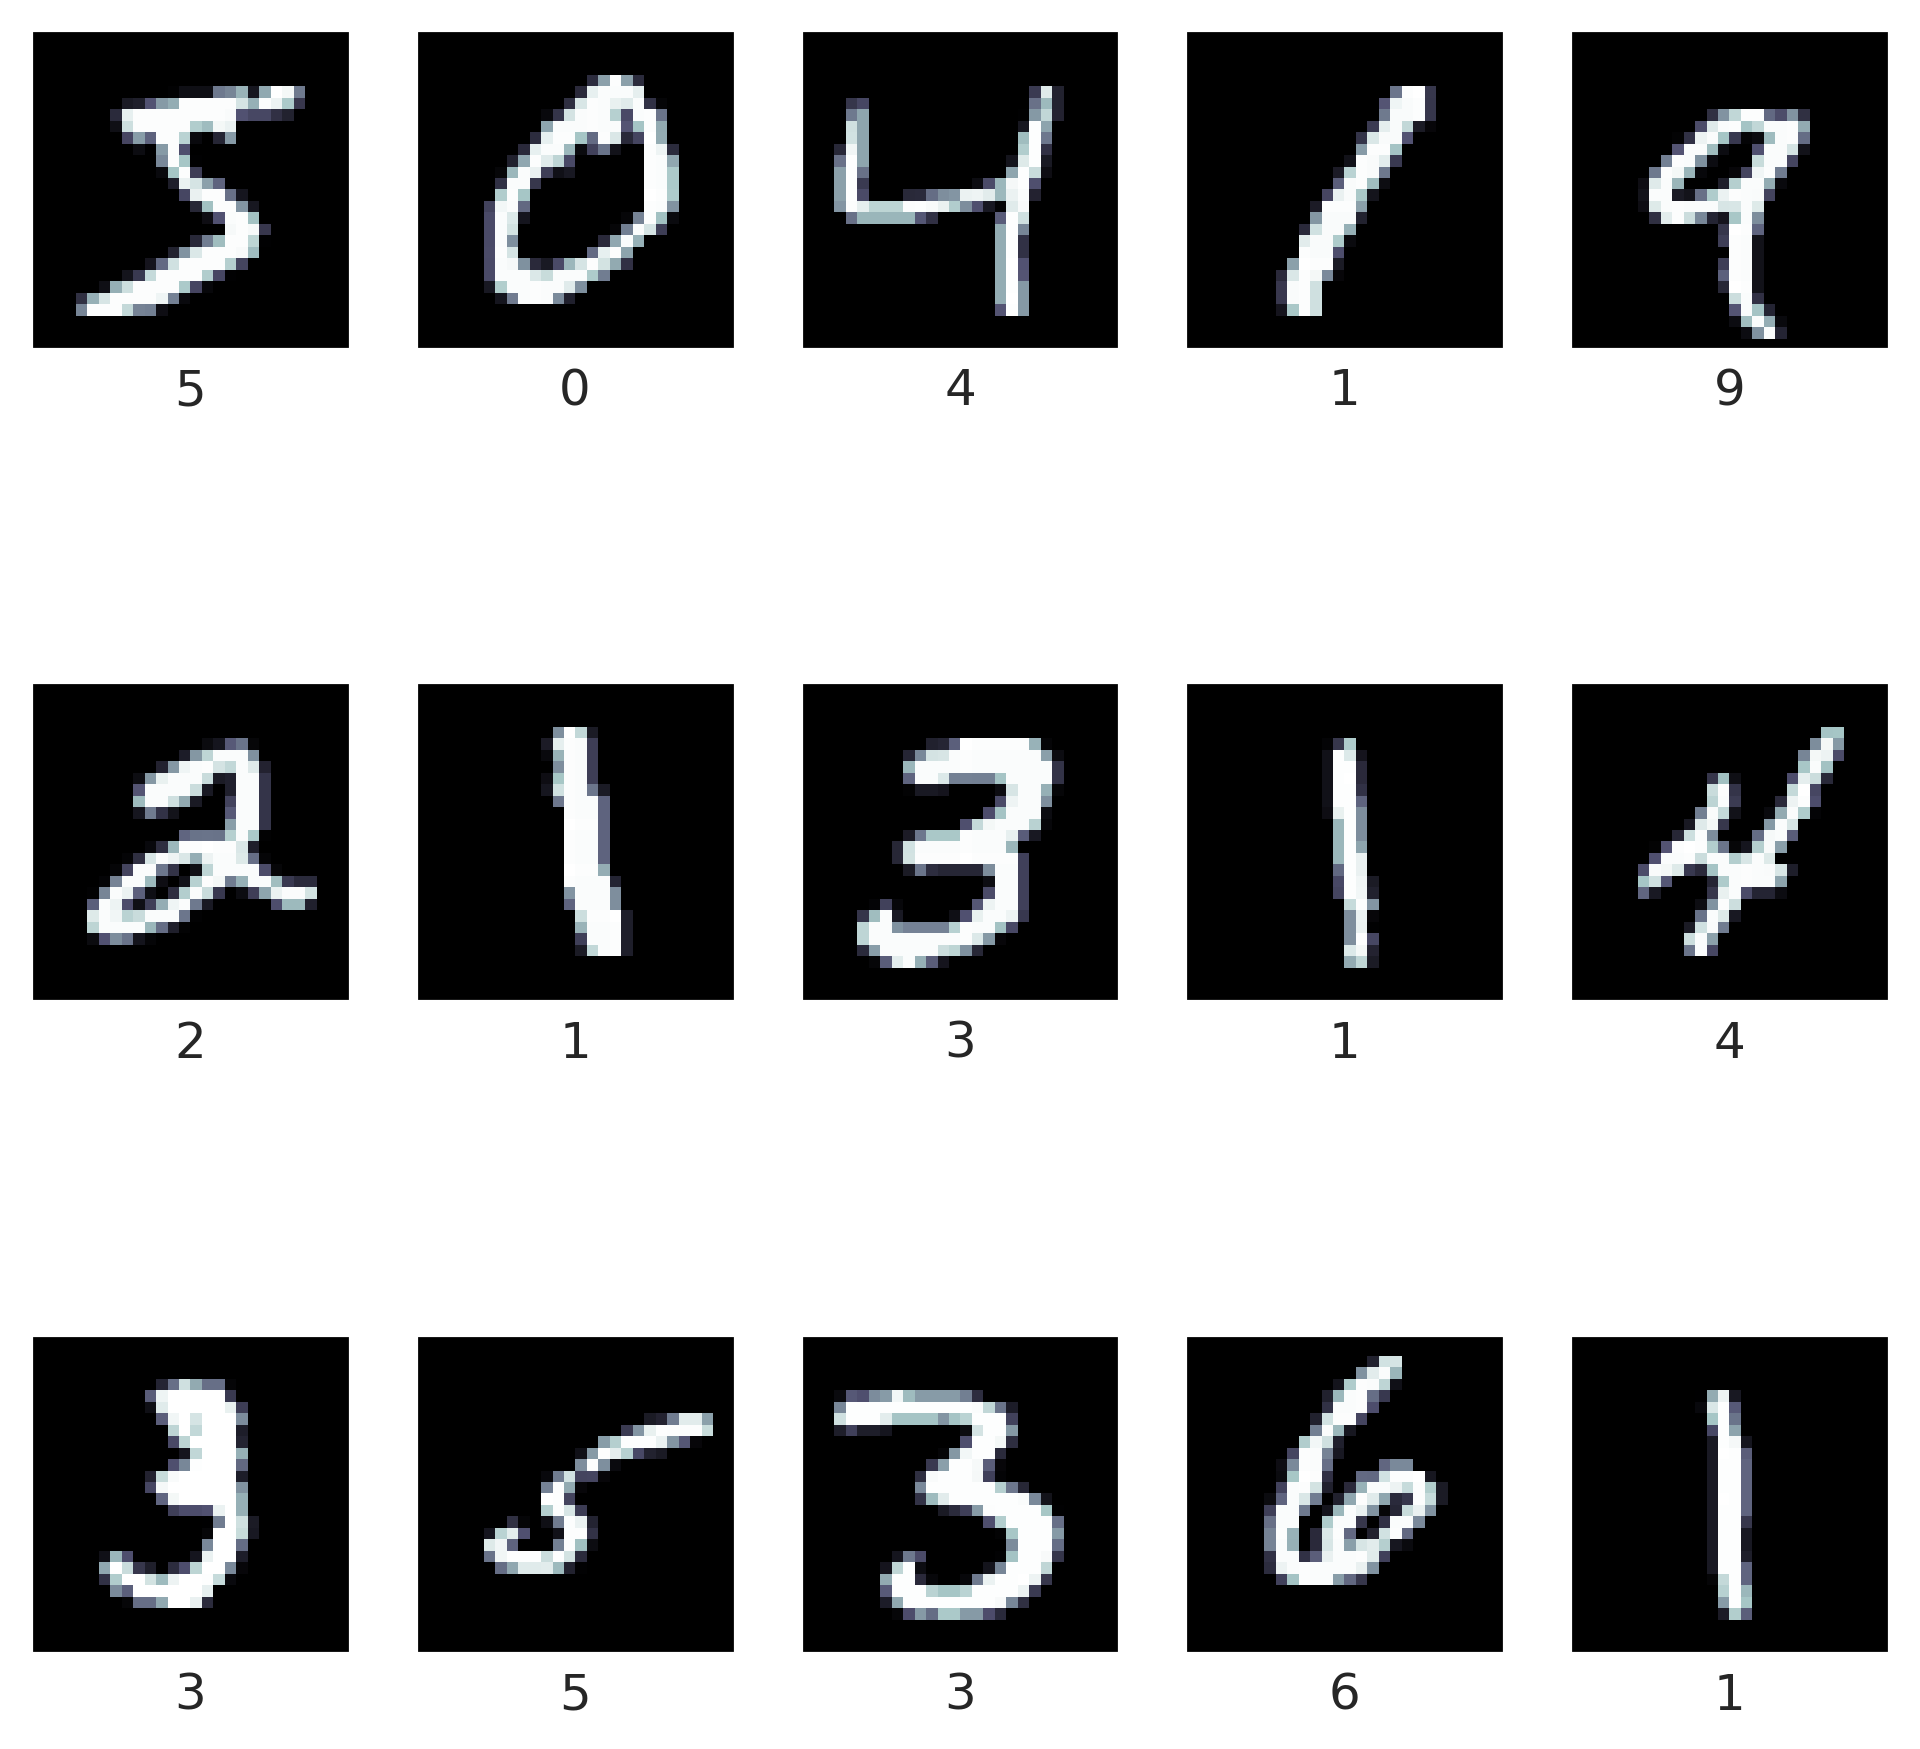

In [14]:
fig, ax = plt.subplots(3, 5, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=str(y_train[i]))

### SVM с линейным ядром

Обучим SVM с линейным ядром чтобы посмотреть.

In [15]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

In [16]:
X_train = X_train.reshape((n_train, X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((n_test, X_test.shape[1] * X_test.shape[2]))

In [17]:
svc = SVC(kernel='linear', class_weight='balanced')
model = svc

In [18]:
model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [19]:
y_fit = model.predict(X_test)

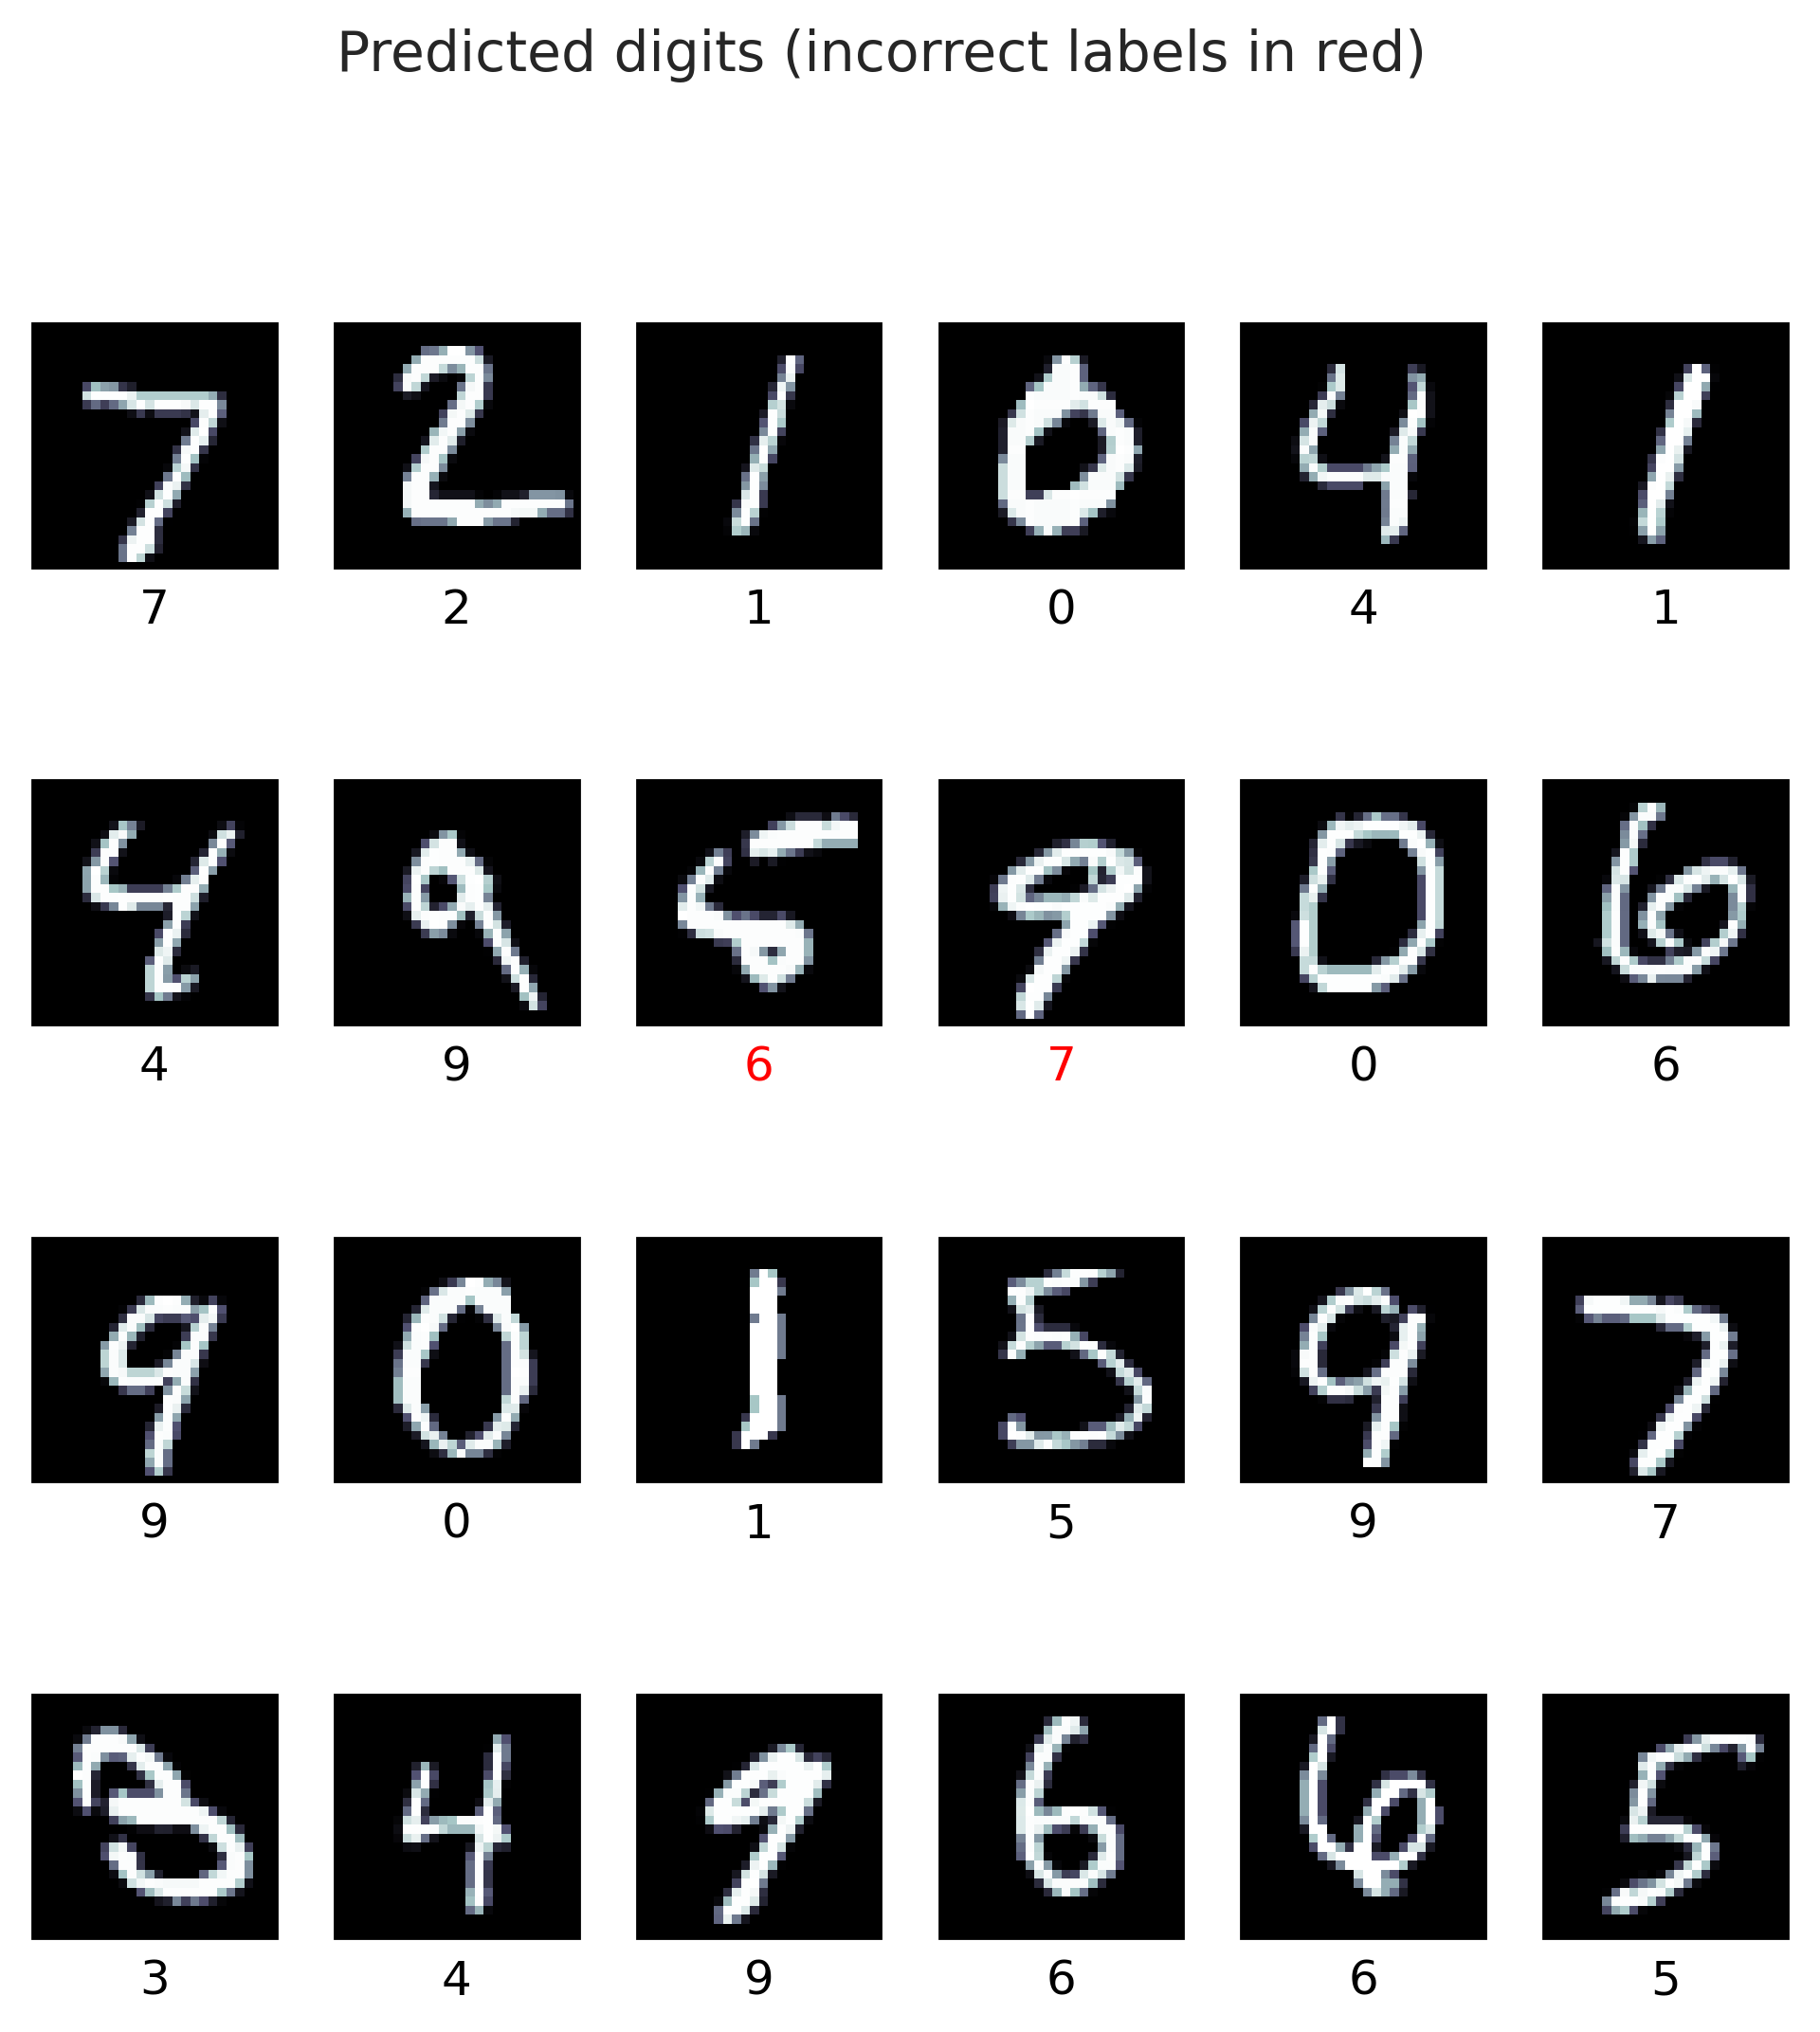

In [20]:
fig, ax = plt.subplots(4, 6, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(28, 28), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y_fit[i], color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('Predicted digits (incorrect labels in red)', size=14)
plt.show()

In [22]:
from sklearn.metrics import classification_report

In [23]:
print(classification_report(y_test, y_fit))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       175
           1       0.95      0.98      0.97       234
           2       0.85      0.89      0.87       219
           3       0.84      0.85      0.84       207
           4       0.89      0.94      0.91       217
           5       0.85      0.86      0.86       179
           6       0.90      0.90      0.90       178
           7       0.89      0.84      0.87       205
           8       0.89      0.78      0.83       192
           9       0.87      0.84      0.85       194

    accuracy                           0.89      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.89      0.88      2000



Лучше всего предсказывается единица (для него самое большое <code>f1-score</code> среди всех классов, цифр).

Выведем значение <code>accuracy_score</code>

In [24]:
accuracy_score(y_test, y_fit)

0.8855

Изобразим матрицу ошибок классификатора (<code>confusion_matrix</code>)

In [25]:
labels = [str(i) for i in range(0, 10)]

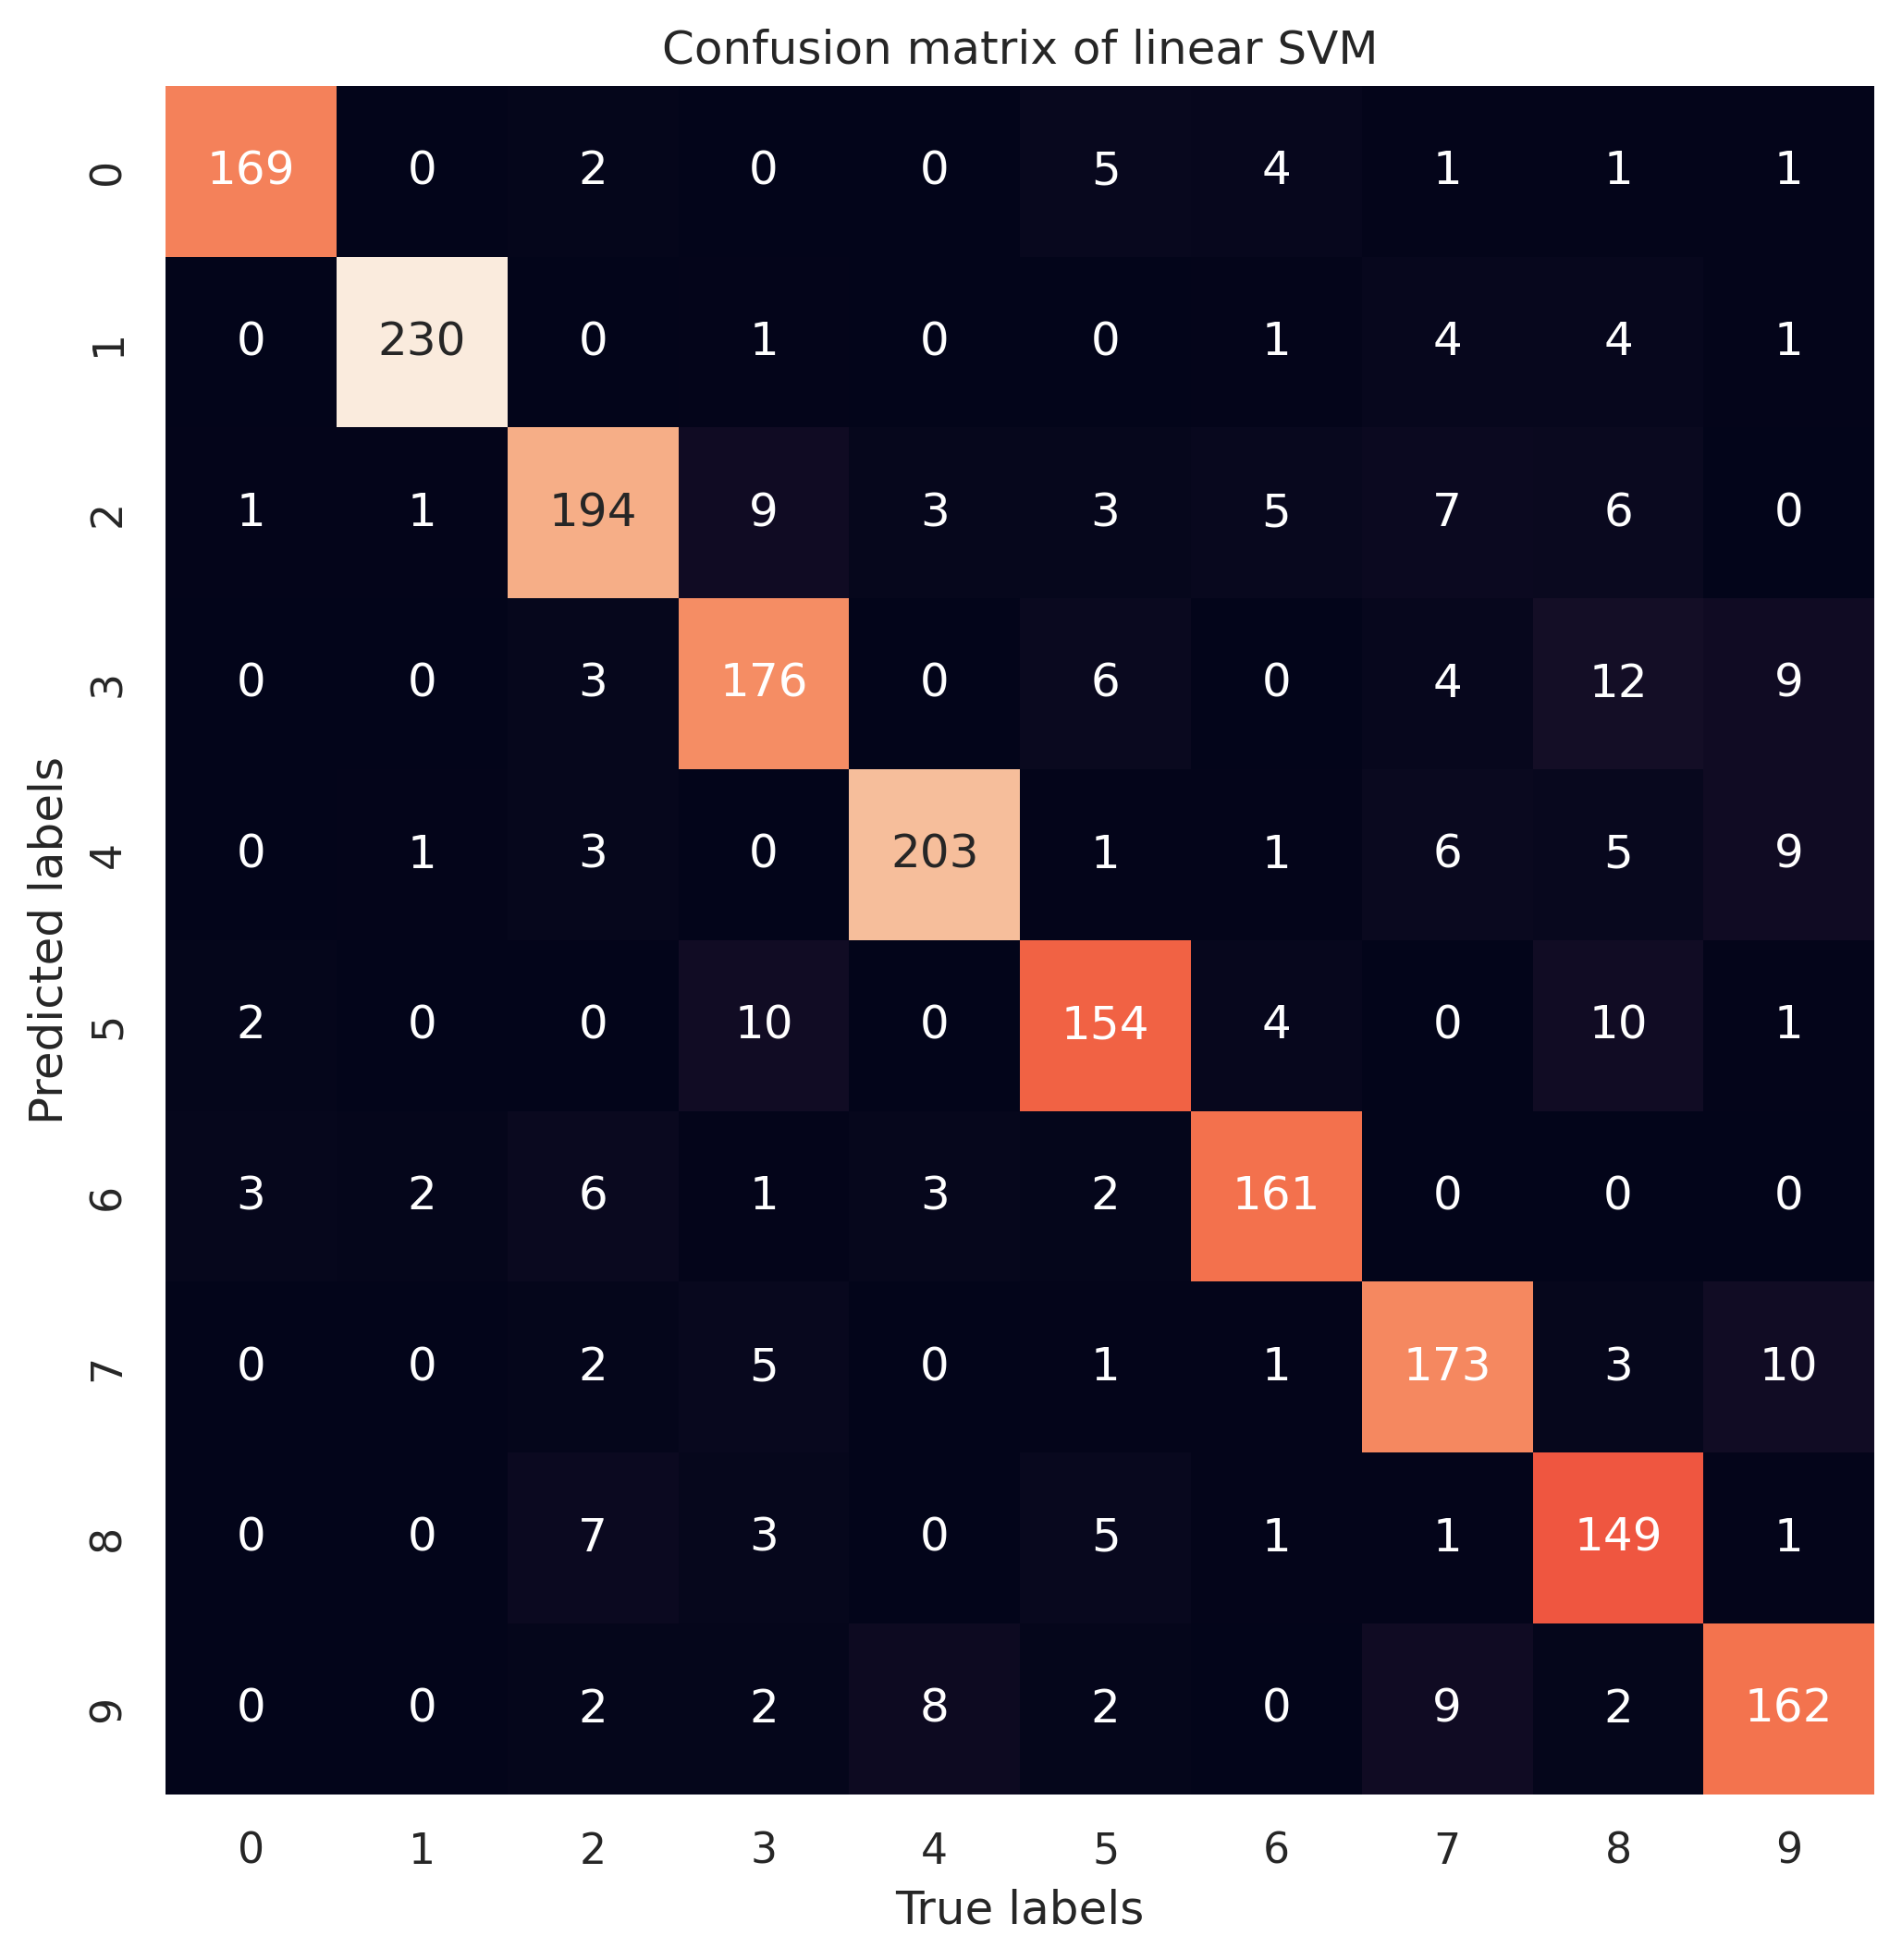

In [26]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
ax.set_title('Confusion matrix of linear SVM')
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
plt.show()

## Применение метода понижения размерности (PCA) и регуляризации SVM

Каждый объект (изображение рукописной цифры) определяется 784 вещественнозначными признаками (количество пикселей в одном изображении). Попробуем сократить количество признаков, используя **метод главных компонент** (PCA).

In [27]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [28]:
pca = PCA(n_components=100, svd_solver='randomized', whiten=True,
          random_state=42)

Также применим регуляризацию для метода опорных векторов, варьируя параметр $C$. Найдем оптимальное значение для параметра регуляризации.

In [29]:
accuracy_train_list = []
accuracy_test_list = []
coefficient = []
c_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2]
for c in c_list:
    svc = SVC(kernel='linear', class_weight='balanced', C=c)
    model = make_pipeline(pca, svc)
    model.fit(X_train, y_train)
    # predict on train
    y_fit_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_fit_train, y_train)
    # predict on test
    y_fit_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_fit_test, y_test)
    
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    print(f'Regularization parameter: {c}')
    print(f'Accuracy score on train: {accuracy_train}')
    print(f'Accuracy score on test: {accuracy_test}')
    print('--------------------')

Regularization parameter: 0.0001
Accuracy score on train: 0.83625
Accuracy score on test: 0.7645
--------------------
Regularization parameter: 0.001
Accuracy score on train: 0.9163333333333333
Accuracy score on test: 0.8625
--------------------
Regularization parameter: 0.01
Accuracy score on train: 0.9449166666666666
Accuracy score on test: 0.8955
--------------------
Regularization parameter: 0.1
Accuracy score on train: 0.9664166666666667
Accuracy score on test: 0.898
--------------------
Regularization parameter: 1
Accuracy score on train: 0.9768333333333333
Accuracy score on test: 0.8915
--------------------
Regularization parameter: 10
Accuracy score on train: 0.9824166666666667
Accuracy score on test: 0.878
--------------------
Regularization parameter: 100.0
Accuracy score on train: 0.9828333333333333
Accuracy score on test: 0.877
--------------------


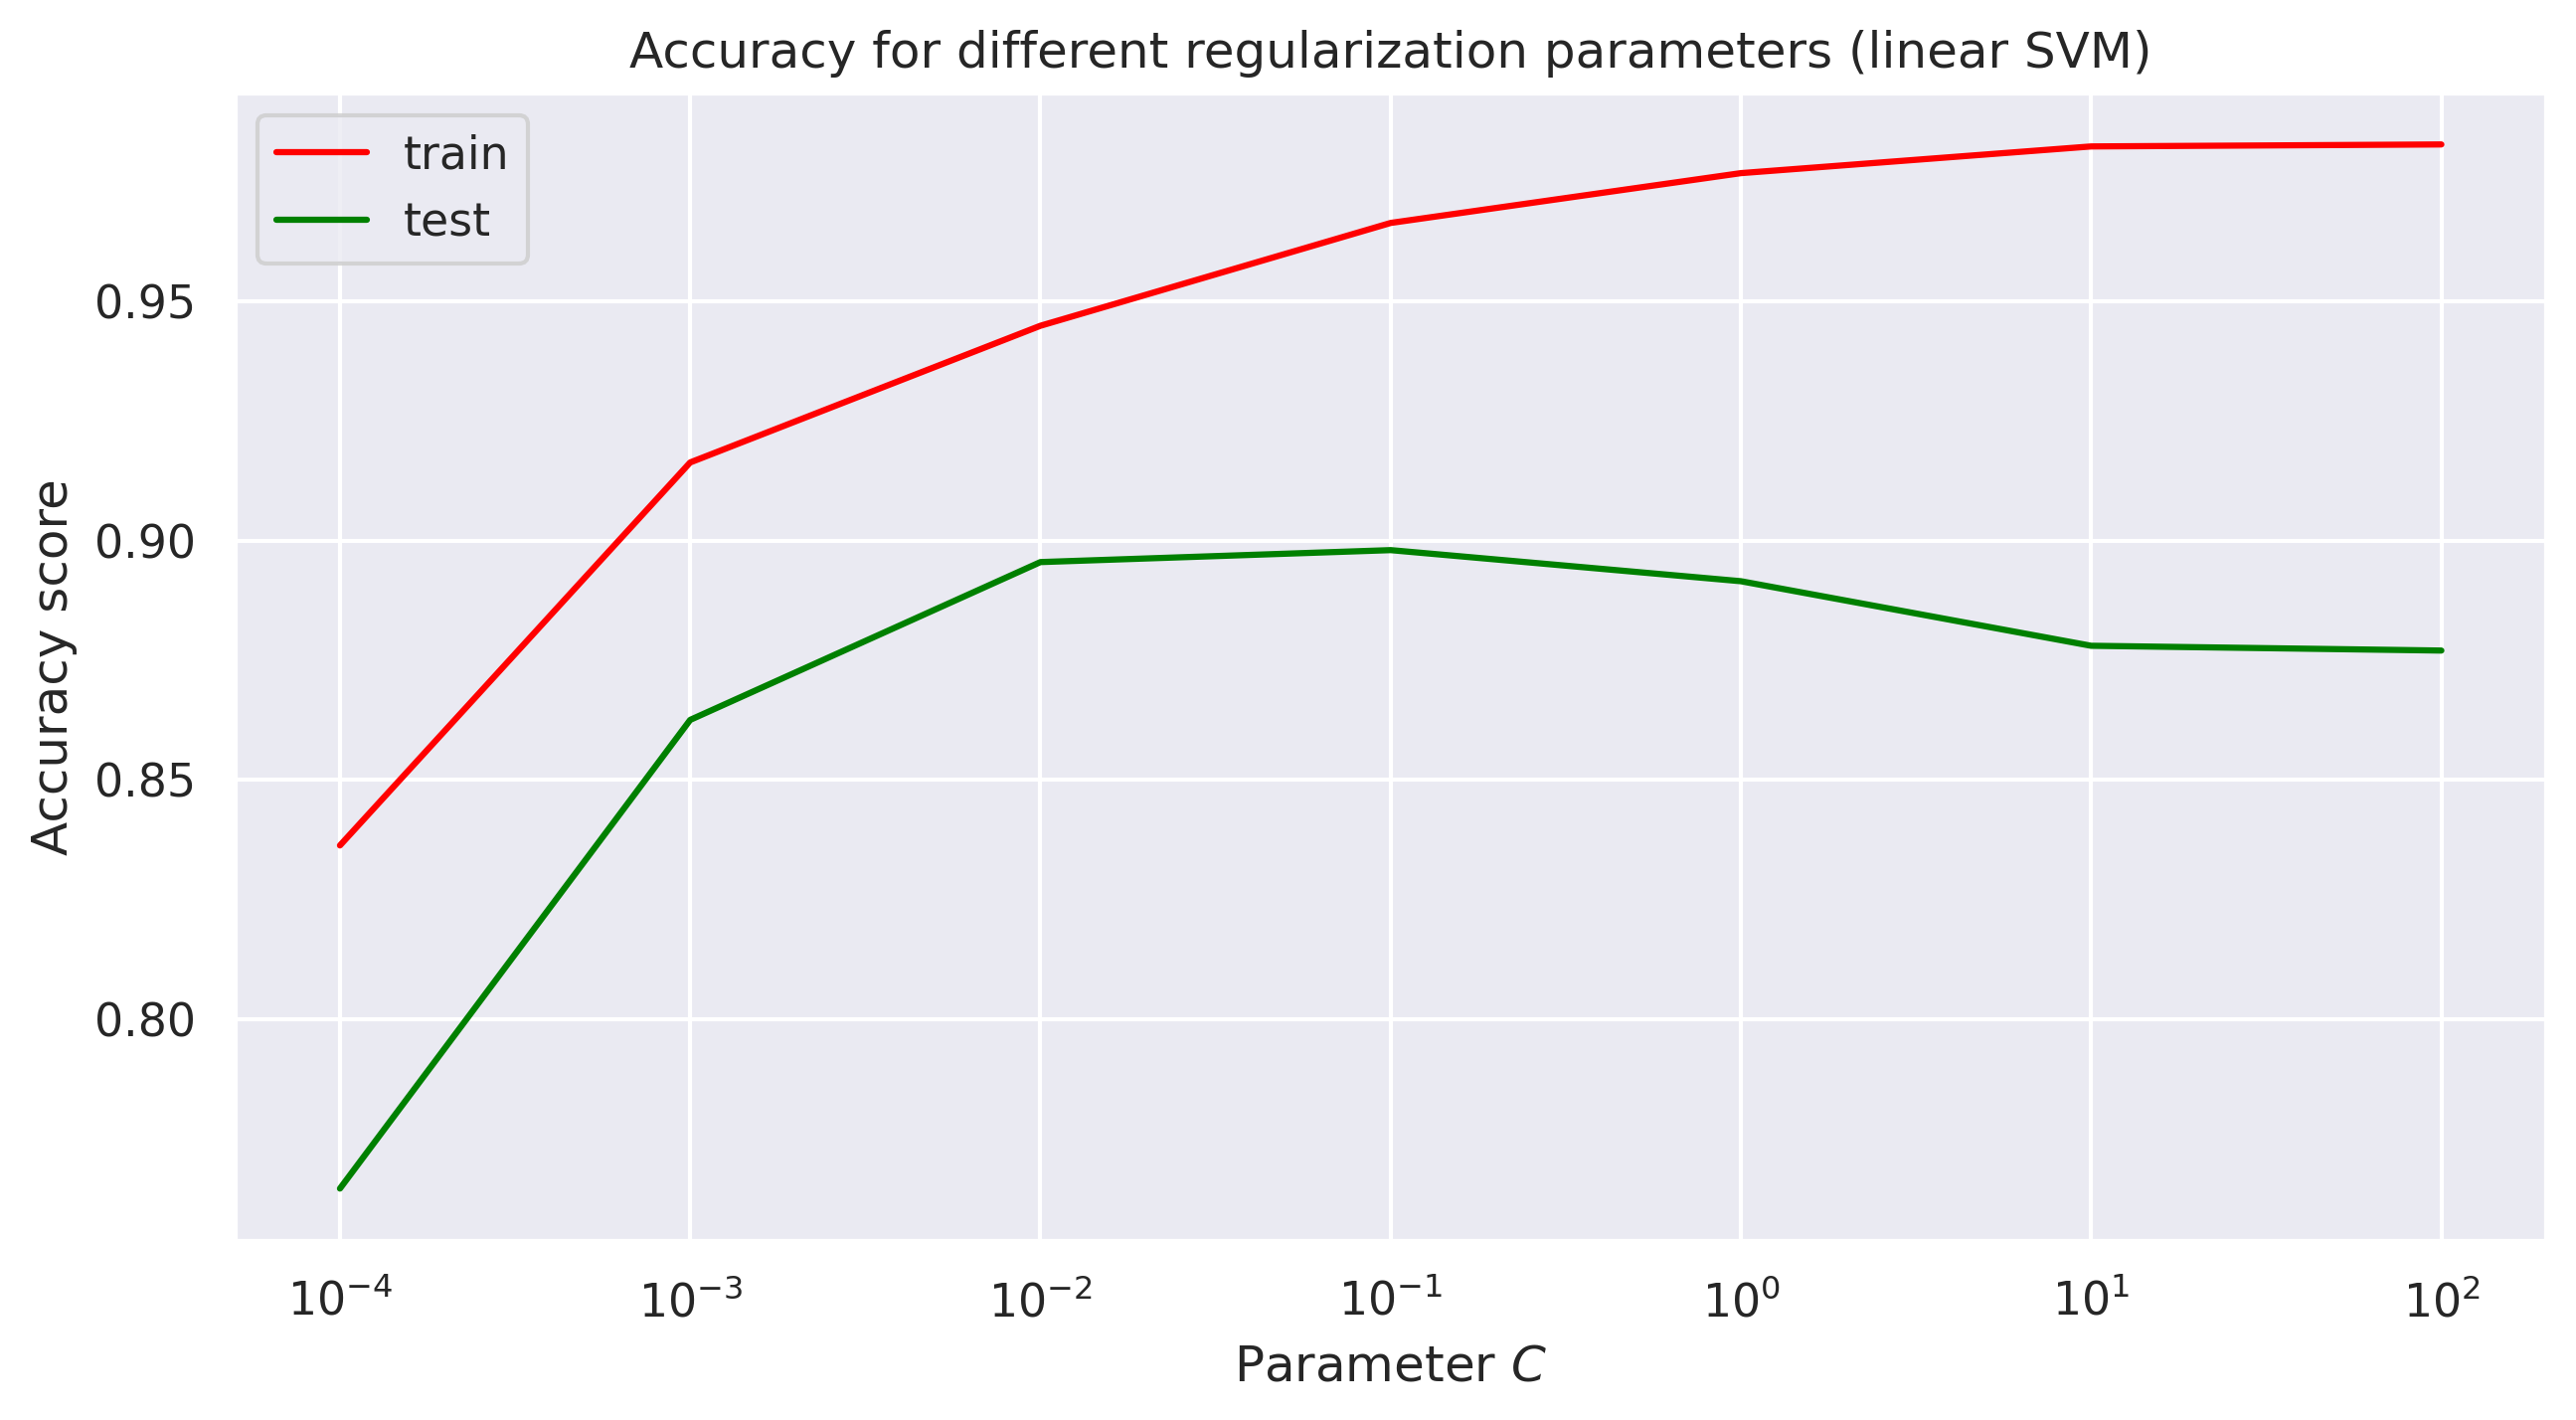

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c_list, accuracy_train_list, color='red', label='train')
ax.plot(c_list, accuracy_test_list, color='green', label='test')
ax.set_xscale('log')
ax.set_xlabel(r'Parameter $C$')
ax.set_ylabel('Accuracy score')
ax.set_title('Accuracy for different regularization parameters (linear SVM)')
plt.legend()
plt.show()

Наибольшего <code>accuracy_score</code> на тестовой выборке удалось достичь при параметре регуляризации $C = 0{,}1$. Использование метода главных компонент позволило чуть-чуть увеличить качество модели.

### Применение различных ядер

Попробуем использовать различные ядра для SVM. Для кажлого ядра осуществим варьирование параметра регуляризации.

In [61]:
from tqdm import tqdm

In [62]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

In [63]:
f1_scores = dict()

In [64]:
best_accuracy_list = []
best_c_list = []
c_list = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1, 10])

for kernel in kernels:
    accuracy_list = np.zeros(shape=c_list.shape)
    for i in tqdm(range(len(c_list))):
        svc = SVC(kernel=kernel, class_weight='balanced', C=c_list[i])
        model = make_pipeline(pca, svc)
        model.fit(X_train, y_train)
        y_fit = model.predict(X_test)
        accuracy_list[i] = accuracy_score(y_test, y_fit)
    best_c = c_list[np.argmax(accuracy_list)]
    
    svc = SVC(kernel=kernel, class_weight='balanced', C=best_c)
    model = make_pipeline(pca, svc)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    
    print(f'Kernel: {kernel}, best regularization parameter {best_c}')
    print(classification_report(y_test, y_fit))
    report = classification_report(y_test, y_fit, output_dict=True)
    f1_scores[kernel] = report['macro avg']['f1-score']

100%|█████████████████████████████████████████████| 6/6 [00:52<00:00,  8.79s/it]


Kernel: linear, best regularization parameter 0.1
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       175
           1       0.95      0.98      0.96       234
           2       0.86      0.92      0.89       219
           3       0.87      0.88      0.87       207
           4       0.92      0.90      0.91       217
           5       0.85      0.84      0.85       179
           6       0.94      0.94      0.94       178
           7       0.90      0.86      0.88       205
           8       0.91      0.82      0.86       192
           9       0.87      0.85      0.86       194

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



100%|█████████████████████████████████████████████| 6/6 [01:46<00:00, 17.80s/it]


Kernel: poly, best regularization parameter 10.0
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       175
           1       0.88      1.00      0.94       234
           2       0.97      0.87      0.92       219
           3       0.89      0.94      0.91       207
           4       0.92      0.94      0.93       217
           5       0.94      0.92      0.93       179
           6       0.95      0.95      0.95       178
           7       0.91      0.91      0.91       205
           8       0.96      0.81      0.88       192
           9       0.92      0.92      0.92       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.92      2000



100%|█████████████████████████████████████████████| 6/6 [01:24<00:00, 14.16s/it]


Kernel: rbf, best regularization parameter 10.0
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       175
           1       0.97      0.98      0.98       234
           2       0.93      0.95      0.94       219
           3       0.92      0.93      0.93       207
           4       0.95      0.97      0.96       217
           5       0.95      0.93      0.94       179
           6       0.94      0.96      0.95       178
           7       0.96      0.91      0.93       205
           8       0.94      0.95      0.95       192
           9       0.96      0.93      0.94       194

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



100%|█████████████████████████████████████████████| 6/6 [01:25<00:00, 14.19s/it]


Kernel: sigmoid, best regularization parameter 1.0
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       175
           1       0.92      0.97      0.94       234
           2       0.89      0.82      0.85       219
           3       0.86      0.85      0.85       207
           4       0.89      0.89      0.89       217
           5       0.79      0.84      0.81       179
           6       0.88      0.88      0.88       178
           7       0.87      0.83      0.85       205
           8       0.81      0.80      0.80       192
           9       0.83      0.84      0.83       194

    accuracy                           0.87      2000
   macro avg       0.86      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



**Вывод:** наибольшее качество модели (значение <code>f1-score</code>) удалось получить для ядра <code>'rbf'</code>, значение коэффициента регуляризации для наилучшей модели $C = 10{,}0$.